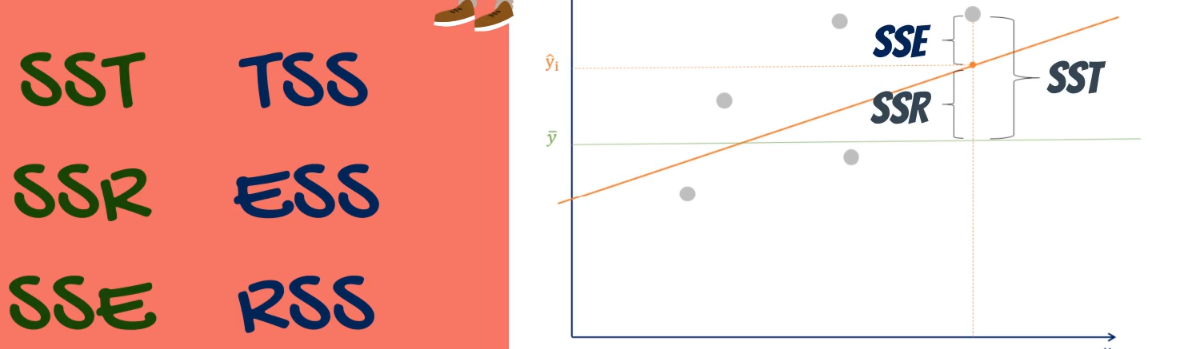

## Importing the relevant libraries

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import itertools
from copy import deepcopy

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from scipy.stats import f, t

np.set_printoptions(precision=15, suppress=False)

sns.set_theme()

## Loading the raw data

In [81]:
df_main = pd.read_csv('cars_dataset.csv')
df = df_main.copy()
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [82]:
df.shape

(4345, 9)

## Preprocessing

### Exploring the Descriptive Statistics of the Variables

In [83]:
df.describe(include='all').round(2)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.00,4345,4345.00,4195.00,4345,4345,4345.00,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.75,NaN,161.24,2.79,NaN,NaN,2006.55,NaN
std,NaN,25584.24,NaN,105.71,5.07,NaN,NaN,6.72,NaN
min,NaN,600.00,NaN,0.00,0.60,NaN,NaN,1969.00,NaN
25%,NaN,6999.00,NaN,86.00,1.80,NaN,NaN,2003.00,NaN
50%,NaN,11500.00,NaN,155.00,2.20,NaN,NaN,2008.00,NaN
75%,NaN,21700.00,NaN,230.00,3.00,NaN,NaN,2012.00,NaN


### Determining the Variables of Interest

In [84]:
df = df.drop(['Model','Registration'], axis=1)

### Dealing with Missing Values

In [85]:
df.isnull().sum()

Brand            0
Price          172
Body             0
Mileage          0
EngineV        150
Engine Type      0
Year             0
dtype: int64

In [86]:
df.dropna(axis=0, ignore_index=True, inplace=True)

In [87]:
df.isnull().sum()

Brand          0
Price          0
Body           0
Mileage        0
EngineV        0
Engine Type    0
Year           0
dtype: int64

In [88]:
df.shape

(4025, 7)

### Exploring the Distribution and Dealing with Outliers

#### Price

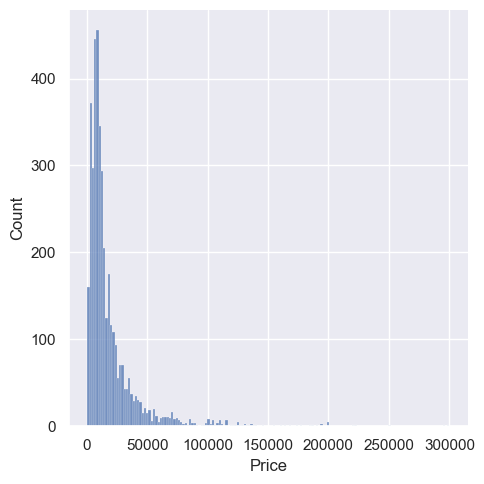

In [89]:
sns.displot(df['Price'])
plt.show()

In [90]:
q = df['Price'].quantile(0.99)
df = df[df['Price']<q]

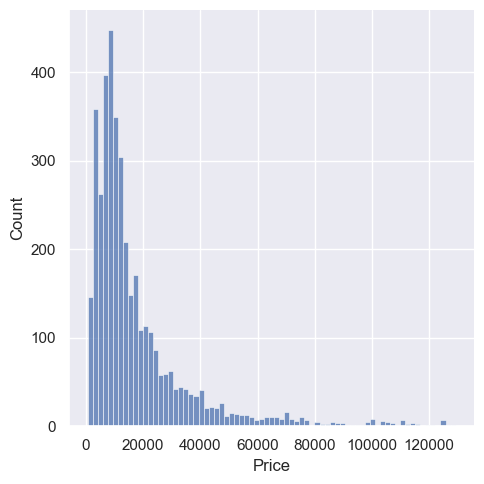

In [91]:
sns.displot(df['Price'])
plt.show()

#### Mileage

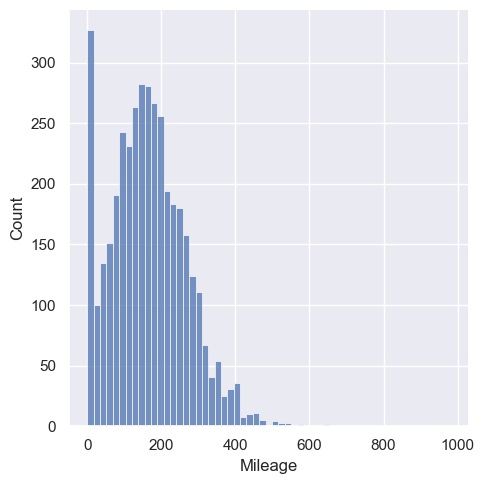

In [92]:
sns.displot(df['Mileage'])
plt.show()

In [93]:
q = df['Mileage'].quantile(0.99)
df = df[df['Mileage']<q]

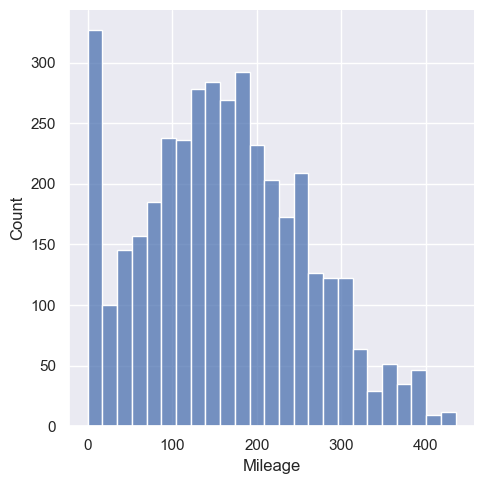

In [94]:
sns.displot(df['Mileage'])
plt.show()

#### EngineV

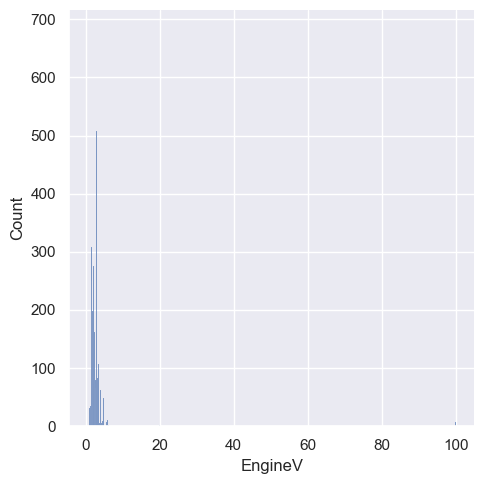

In [95]:
sns.displot(df['EngineV'])
plt.show()

In [96]:
df = df[df['EngineV']<6.5]

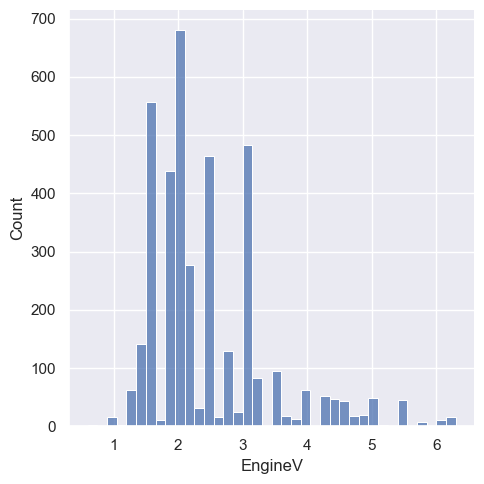

In [97]:
sns.displot(df['EngineV'])
plt.show()

#### Year

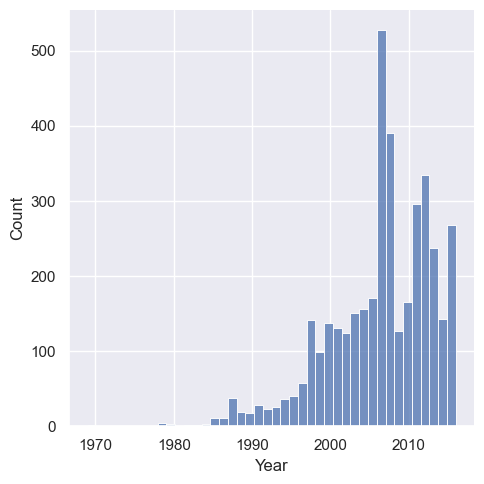

In [98]:
sns.displot(df['Year'])
plt.show()

In [99]:
q = df['Year'].quantile(0.01)
df = df[df['Year']>q]

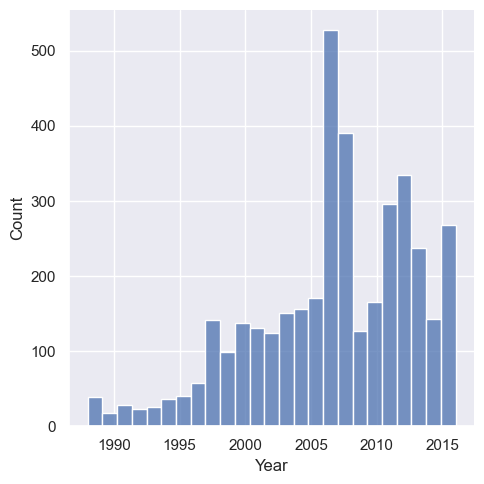

In [100]:
sns.displot(df['Year'])
plt.show()

In [101]:
df.reset_index(drop=True, inplace=True)

## Categorizing Variables

In [102]:
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,2011


In [103]:
df.nunique()

Brand            7
Price          849
Body             6
Mileage        377
EngineV         55
Engine Type      4
Year            29
dtype: int64

In [104]:
# Initialize BinaryEncoder
onehot_encoder = ce.OneHotEncoder(use_cat_names=True)

# Fit and transform the data
df_encoded = onehot_encoder.fit_transform(df)

In [105]:
df_encoded.head()

,Brand_BMW,Brand_Mercedes-Benz,Brand_Audi,Brand_Toyota,Brand_Renault,Brand_Volkswagen,Brand_Mitsubishi,Price,Body_sedan,Body_van,...,Body_vagon,Body_other,Body_hatch,Mileage,EngineV,Engine Type_Petrol,Engine Type_Diesel,Engine Type_Gas,Engine Type_Other,Year
0,1,0,0,0,0,0,0,4200.0,1,0,...,0,0,0,277,2.0,1,0,0,0,1991
1,0,1,0,0,0,0,0,7900.0,0,1,...,0,0,0,427,2.9,0,1,0,0,1999
2,0,1,0,0,0,0,0,13300.0,1,0,...,0,0,0,358,5.0,0,0,1,0,2003
3,0,0,1,0,0,0,0,23000.0,0,0,...,0,0,0,240,4.2,1,0,0,0,2007
4,0,0,0,1,0,0,0,18300.0,0,0,...,0,0,0,120,2.0,1,0,0,0,2011


In [106]:
df_encoded.columns

Index(['Brand_BMW', 'Brand_Mercedes-Benz', 'Brand_Audi', 'Brand_Toyota',
       'Brand_Renault', 'Brand_Volkswagen', 'Brand_Mitsubishi', 'Price',
       'Body_sedan', 'Body_van', 'Body_crossover', 'Body_vagon', 'Body_other',
       'Body_hatch', 'Mileage', 'EngineV', 'Engine Type_Petrol',
       'Engine Type_Diesel', 'Engine Type_Gas', 'Engine Type_Other', 'Year'],
      dtype='object')

In [107]:
df_encoded.dtypes

Brand_BMW                int64
Brand_Mercedes-Benz      int64
Brand_Audi               int64
Brand_Toyota             int64
Brand_Renault            int64
Brand_Volkswagen         int64
Brand_Mitsubishi         int64
Price                  float64
Body_sedan               int64
Body_van                 int64
Body_crossover           int64
Body_vagon               int64
Body_other               int64
Body_hatch               int64
Mileage                  int64
EngineV                float64
Engine Type_Petrol       int64
Engine Type_Diesel       int64
Engine Type_Gas          int64
Engine Type_Other        int64
Year                     int64
dtype: object

In [108]:
df_encoded.nunique()

Brand_BMW                2
Brand_Mercedes-Benz      2
Brand_Audi               2
Brand_Toyota             2
Brand_Renault            2
Brand_Volkswagen         2
Brand_Mitsubishi         2
Price                  849
Body_sedan               2
Body_van                 2
Body_crossover           2
Body_vagon               2
Body_other               2
Body_hatch               2
Mileage                377
EngineV                 55
Engine Type_Petrol       2
Engine Type_Diesel       2
Engine Type_Gas          2
Engine Type_Other        2
Year                    29
dtype: int64

## Checking the OLS assumptions

In [109]:
y = df_encoded["Price"]
X = df_encoded.drop("Price", axis=1)

### Linearity

In [110]:
# Identify boolean-like columns (columns with only 0 and 1)
X_boolean = [col for col in X.columns if set(X[col].unique()).issubset({0, 1})]

# Exclude boolean-like columns and select only continuous columns
X_nonboolean = X.drop(columns=X_boolean, axis=0)

# Display the new DataFrame
print(X_nonboolean)

      Mileage  EngineV  Year
0         277      2.0  1991
1         427      2.9  1999
2         358      5.0  2003
3         240      4.2  2007
4         120      2.0  2011
...       ...      ...   ...
3862      163      2.5  2008
3863       35      1.6  2014
3864        9      3.0  2014
3865        1      3.5  1999
3866      124      2.0  2013

[3867 rows x 3 columns]


In [111]:
def regression_plot(x, y):

    b1_slope, b0_intercept = np.polyfit(x, y, 1)
    y_pred = b0_intercept + x * b1_slope

    plt.figure(figsize=(6,3))
    plt.title(x.name + " and " + y.name)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red', label='Regression Line')
    plt.show()

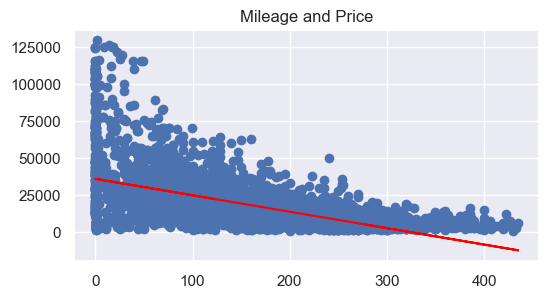

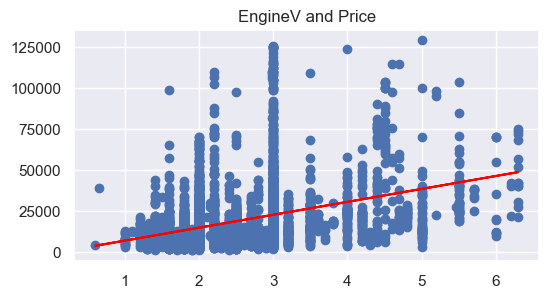

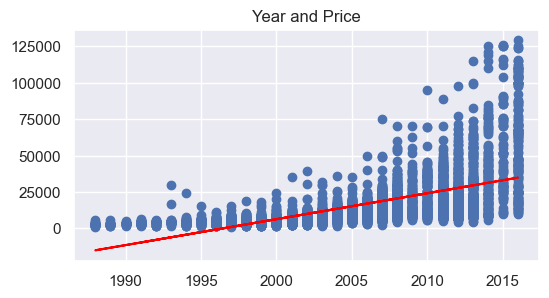

In [112]:
for col in X_nonboolean.columns:
    regression_plot(X[col], y)

In [113]:
price_log = pd.Series(np.log(y), name="Price_log")

In [114]:
price_log.head()

0     8.342840
1     8.974618
2     9.495519
3    10.043249
4     9.814656
Name: Price_log, dtype: float64

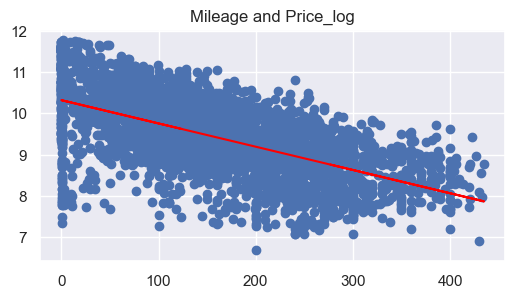

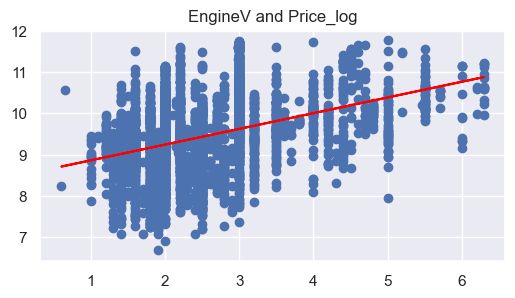

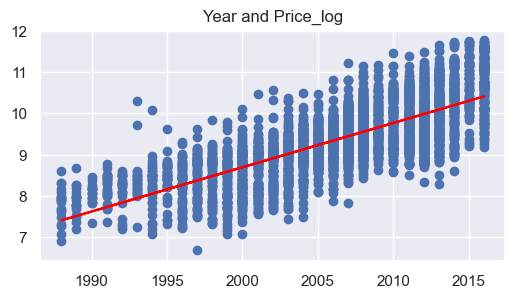

In [115]:
for col in X_nonboolean.columns:
    regression_plot(X[col], price_log)

In [116]:
y = price_log

In [117]:
del price_log

### No Endogeneity / Exogeneity

In [118]:
x = sm.add_constant(X)
# Fit the OLS model
model = sm.OLS(y, x).fit()
residuals = model.resid

X["residuals"] = residuals

In [119]:
resid_corr = X.corr().loc[["residuals"],:"Year"] 
resid_corr

,Brand_BMW,Brand_Mercedes-Benz,Brand_Audi,Brand_Toyota,Brand_Renault,Brand_Volkswagen,Brand_Mitsubishi,Body_sedan,Body_van,Body_crossover,Body_vagon,Body_other,Body_hatch,Mileage,EngineV,Engine Type_Petrol,Engine Type_Diesel,Engine Type_Gas,Engine Type_Other,Year
residuals,-6.118650e-14,-9.864225e-14,-5.990603e-15,1.489542e-13,-1.334955e-14,-1.387484e-14,8.756702e-14,-1.703391e-13,-1.621752e-14,2.010932e-13,-4.864163e-14,5.642863e-15,8.081439e-14,-6.509465e-13,-8.549700e-15,1.085737e-13,4.924754e-15,-1.464713e-13,-1.723676e-14,5.108022e-13


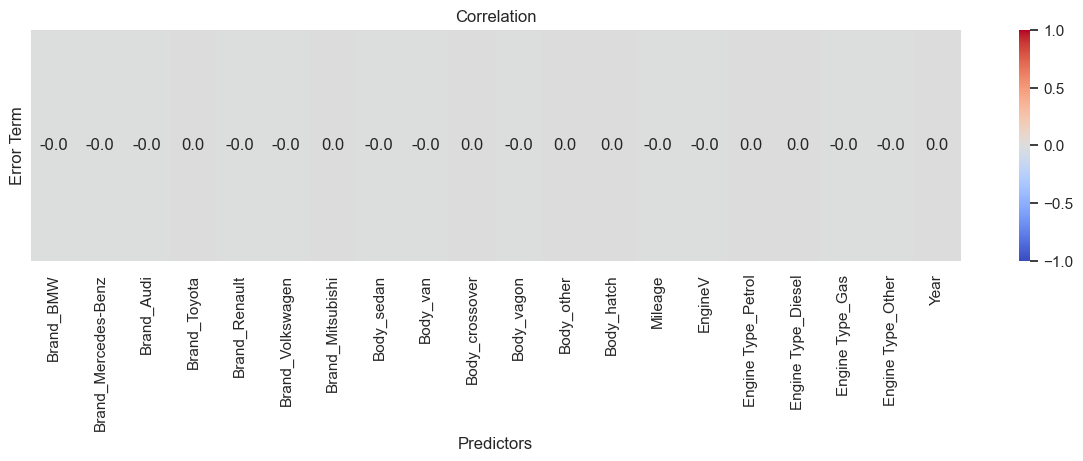

In [120]:
# Heatmap of Numeric Values Only
plt.figure(figsize=(15,3))
sns.heatmap(resid_corr, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            annot_kws={"rotation": 0},
            fmt=".1f"
)

plt.title('Correlation')
plt.ylabel('Error Term')
plt.yticks([])
plt.xlabel('Predictors')
plt.xticks(rotation=90)
plt.show()

In [121]:
X.drop("residuals", axis=1, inplace=True)

### Homoscedasticity / Constant Error Variance / No Heteroscedasticity

In [122]:
# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, model.model.exog) 

# Get the p-value
p_value = bp_test[1] 

# Print the results
print(f"Breusch-Pagan Test p-value for the Model: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis of homoscedasticity.")
    print("There is evidence of heteroscedasticity.")
    print(f"The model is significant.\n")
else:
    print("Fail to reject the null hypothesis of homoscedasticity.")
    print("There is no evidence of heteroscedasticity.")
    print(f"The model is insignificant.\n")

Breusch-Pagan Test p-value for the Model: 8.022411860683714e-58
Reject the null hypothesis of homoscedasticity.
There is evidence of heteroscedasticity.
The model is significant.



### No Autocorrelation / Independant Error Terms / No Serial Correlation

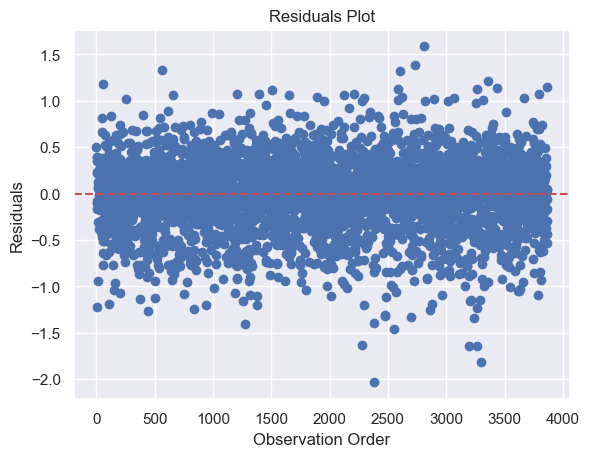

In [123]:
plt.scatter(residuals.index, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Observation Order")
plt.ylabel("Residuals")
plt.show()

In [124]:
# Range from 0 to 4, closer to 2 means no auto-correlation
dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_statistic}")

Durbin-Watson Statistic: 2.0128097652021935


### No Multicollinearity

#### Corr

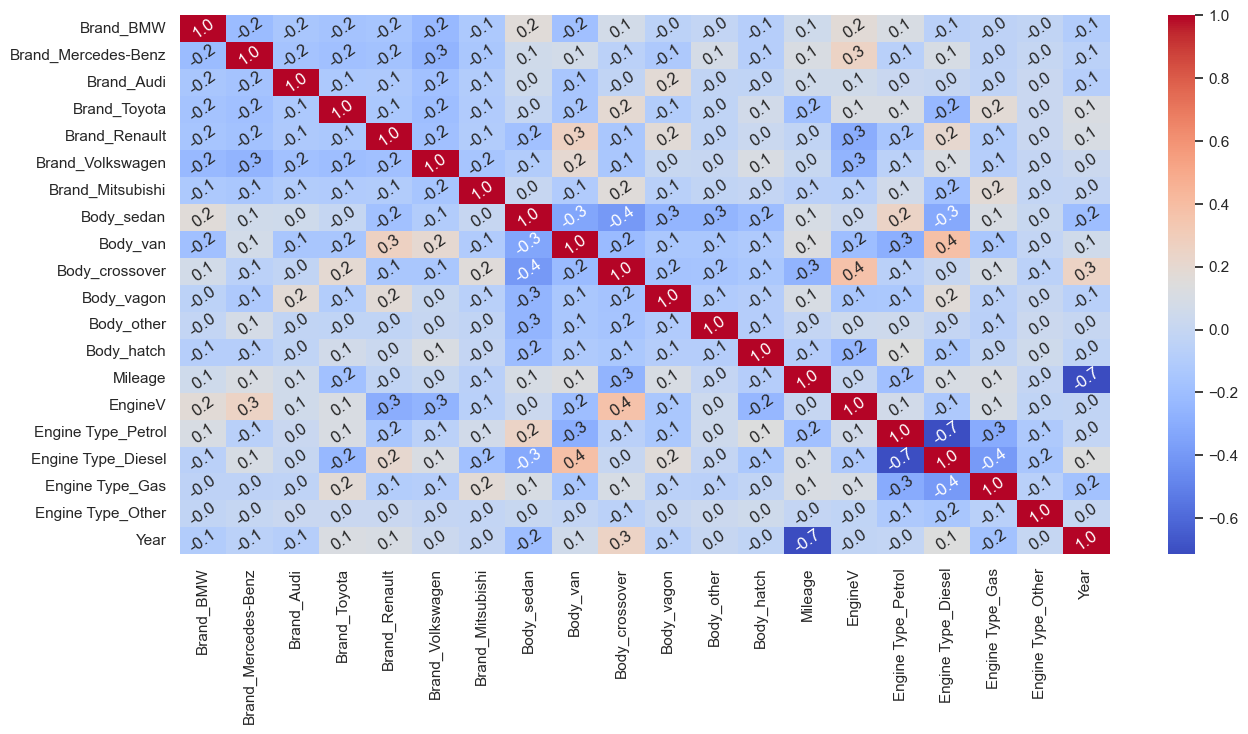

In [125]:
corr_matrix = X.corr()

plt.figure(figsize=(15,7))
sns.heatmap(corr_matrix, 
            annot=True,
            annot_kws={"rotation": 35},
            cmap='coolwarm', 
            fmt=".1f")
plt.xticks(rotation=90)
plt.show()

#### VIF

In [131]:
drop_col = ["Year", "EngineV"]

X_multi_test = deepcopy(X)
X_multi_test.drop(columns=drop_col, axis=1, inplace=True)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_multi_test.columns
vif_data["VIF"] = [variance_inflation_factor(X_multi_test.values, i) for i in range(X_multi_test.shape[1])]
print(vif_data)

               Variable       VIF
0             Brand_BMW       inf
1   Brand_Mercedes-Benz       inf
2            Brand_Audi       inf
3          Brand_Toyota       inf
4         Brand_Renault       inf
5      Brand_Volkswagen       inf
6      Brand_Mitsubishi       inf
7            Body_sedan       inf
8              Body_van       inf
9        Body_crossover       inf
10           Body_vagon       inf
11           Body_other       inf
12           Body_hatch       inf
13              Mileage  1.202536
14   Engine Type_Petrol       inf
15   Engine Type_Diesel       inf
16      Engine Type_Gas       inf
17    Engine Type_Other       inf


c:\Users\aldan\Desktop\Data_Scientist\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


#### Condt Num

In [127]:
class ols_wrapper(LinearRegression):
    
    def __init__(self, X, y):
        super(ols_wrapper, self).__init__(fit_intercept=False)

        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=123)
        
        self.fit(self.X_train, self.y_train)
        self.y_pred = self.predict(self.X_train)     
        self.y_mean = np.mean(self.y_train)

        self.rank = np.linalg.matrix_rank(self.X_train)  
        # Number of samples
        self.n_obs = self.X_train.shape[0]  
        # Number of predictors without multicollinearity
        self.p_rank = self.rank - 1 
        # Degrees of freedom
        self.dof = self.n_obs - self.p_rank  # Degrees of freedom n_obs-p-1
        self.dof_resid = self.dof - 1   # Degress of freedom residuals

        #residuals
        self.resid = self.y_train - self.y_pred

        # SST (Total Sum of Squares)
        self.sst = np.sum((self.y_train - self.y_mean) ** 2)

        # SSR (Regression Sum of Squares)
        self.ssr = np.sum((self.y_pred - self.y_mean) ** 2)

        # SSE (Error Sum of Squares) / Residuals Squared
        self.sse = np.sum(self.resid**2)

        # MSR (Mean Square Regression)
        self.msr = self.ssr / self.p_rank

        # MSE (Mean Square Error of the Residuals/ Residual Variance)
        self.mse = self.sse / self.dof_resid

        # r2 train
        self.rsquared = self.ssr/self.sst

        # adjusted r2
        self.adj_rsquared = 1 - (1 - self.rsquared) * (self.n_obs - 1) / self.dof

        # cond number
        self.condition_number = np.linalg.cond(self.X_train)

        # fstatistic
        self.f_stat = self.msr / self.mse

        # fpvalue
        self.f_pvalue = 1 - f.cdf(self.f_stat, self.p_rank, self.dof_resid)

        # standard error 
        self.pinv_wexog = np.linalg.pinv(self.X_train)
        self.normalized_cov_params = np.dot(self.pinv_wexog, np.transpose(self.pinv_wexog))
        self.std_errors = np.sqrt(np.diag(self.normalized_cov_params * self.mse))

        # tstats
        self.t_stat = self.coef_ / self.std_errors

        # pvalues
        self.pvalues = t.sf(np.abs(self.t_stat), self.dof_resid) * 2

        # log-likelihood
        self.log_likelihood = -0.5 * self.n_obs * (np.log(2 * np.pi) + np.log(self.sse / self.n_obs) + 1)

In [ ]:
cols = X_multi_test.columns

all_combinations = []

data_dict = {
    "combination" : [],
    "combination_numb" : [],
    "sum_pvalues" : [],
    "sm_sum_pvalues" : [],
    "rsquared" : [],
    "sm_rsquared" : [],
    "adj_rsquared" : [],
    "sm_adj_rsquared" : [],
    "f_stat" : [],
    "sm_f_stat" : [],
    "f_p_stat" : [],
    "sm_f_p_stat" : [],
    "condition_number" : [],
    "sm_condition_number" : [],
    "log_likelihood" : [],
    "sm_log_likelihood" : []
}

for r in range(1, len(cols) + 1):
    combinations = itertools.combinations(cols, r)
    all_combinations.extend(combinations)

filtered_combination = [comb for comb in all_combinations if "Mileage" in comb]

for comb in filtered_combination:
    x = sm.add_constant(X_multi_test[list(comb)])
    model = ols_wrapper(x,y)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
    model_sm = sm.OLS(y_train, X_train).fit()

    data_dict["combination"].append(comb)
    data_dict["combination_numb"].append(len(comb))

    p_val = sum(model.pvalues)
    sm_p_val = sum(model_sm.pvalues)
    data_dict["sum_pvalues"].append(round(p_val,3)) 
    data_dict["sm_sum_pvalues"].append(round(sm_p_val,3)) 

    data_dict["rsquared"].append(model.rsquared) 
    data_dict["sm_rsquared"].append(model_sm.rsquared) 

    data_dict["adj_rsquared"].append(model.adj_rsquared) 
    data_dict["sm_adj_rsquared"].append(model_sm.rsquared_adj) 

    data_dict["f_stat"].append(model.f_stat) 
    data_dict["sm_f_stat"].append(model_sm.fvalue) 

    data_dict["f_p_stat"].append(model.f_pvalue) 
    data_dict["sm_f_p_stat"].append(model_sm.f_pvalue) 

    data_dict["condition_number"].append(model.condition_number) 
    data_dict["sm_condition_number"].append(model_sm.condition_number) 

    data_dict["log_likelihood"].append(model.log_likelihood) 
    data_dict["sm_log_likelihood"].append(model_sm.llf)   

In [ ]:
df_model = pd.DataFrame.from_dict(data_dict)
df_model

In [ ]:
df_model.to_csv("filtered_combinations.csv")

In [ ]:
models_df = pd.read_csv("filtered_combinations.csv", index_col=0)

models_df = models_df[models_df["sum_pvalues"] < 0.01]

models_df = models_df[models_df["condition_number"] < 1000]

models_df.sort_values(by="rsquared", ascending=False, inplace=True)

models_df.reset_index(drop=1, inplace=True)

models_df["len"] = models_df["combination"].apply(lambda x: len(x.split(",")))

for i in models_df["len"].unique():
    idxmax = models_df[models_df["len"] == i]["rsquared"].idxmax()
    print(f"{models_df.loc[idxmax]}")

## Linear regression model

### Features and Target

In [ ]:
X = deepcopy(X_multi_test)
X.head()

In [ ]:
y.head()

In [ ]:
import itertools

# Input list
data = X.columns

# Generate combinations of length 2
all_combinations = []
columns_dict = {
    "combination":[],
    "r_squared":[],
    "notes":[]
}

# Convert the iterator to a list and print

for r in range(1, len(data) + 1):
    combinations = itertools.combinations(data, r)
    all_combinations.extend(combinations)

max_len = len(all_combinations)

for idx, combination in enumerate(all_combinations):
    x = sm.add_constant(X[list(combination)])
    model = sm.OLS(y,x).fit()

    # Extract R-squared
    r_squared = model.rsquared

    # Extract notes from the summary table
    notes = model.summary().extra_txt.split("[1]")[1]

    columns_dict["combination"].append(combination)
    columns_dict["r_squared"].append(r_squared)
    columns_dict["notes"].append(notes)

In [ ]:
comb_df["notes"][1001]

In [ ]:
model.summary()

In [ ]:
comb_df = pd.DataFrame(columns_dict).sort_values(by="r_squared", ascending=False)

In [ ]:
comb_df["notes_bool"] = comb_df["notes"].apply(lambda x: "multicollinearity" in x)

In [ ]:
comb_df["combination_len"] = comb_df["combination"].apply(lambda x: len(x))

In [ ]:
comb_df_new = comb_df[comb_df.notes_bool == False].sort_values(by=["combination_len","r_squared"], ascending=False)

In [ ]:
new_features = list(comb_df.loc[32570, "combination"])

In [ ]:
new_features.extend(reference_level)

In [ ]:
onehot_encoder = ce.OneHotEncoder(use_cat_names=True)

# Fit and transform the data
df_encoded = onehot_encoder.fit_transform(df)

In [ ]:
df_encoded = df_encoded[new_features]

In [ ]:
# Input list
data = df_encoded[new_features].columns

# Generate combinations of length 2
all_combinations = []
columns_dict1 = {
    "combination":[],
    "r_squared":[],
    "notes":[]
}

# Convert the iterator to a list and print

for r in range(1, len(data) + 1):
    combinations = itertools.combinations(data, r)
    all_combinations.extend(combinations)

max_len = len(all_combinations)

for idx, combination in enumerate(all_combinations):
    x = sm.add_constant(df_encoded[list(combination)])
    model = sm.OLS(y,x).fit()

    # Extract R-squared
    r_squared = model.rsquared

    # Extract notes from the summary table
    notes = model.summary().extra_txt.split("[1]")[1]

    columns_dict1["combination"].append(combination)
    columns_dict1["r_squared"].append(r_squared)
    columns_dict1["notes"].append(notes)

In [ ]:
comb_df1 = pd.DataFrame(columns_dict).sort_values(by="r_squared", ascending=False)
comb_df1["notes_bool"] = comb_df1["notes"].apply(lambda x: "multicollinearity" in x)
comb_df1["combination_len"] = comb_df1["combination"].apply(lambda x: len(x))

In [ ]:
comb1df_ = comb_df1[comb_df1.notes_bool != True]

In [ ]:
comb_df2 = comb1df_[comb1df_["r_squared"] > 0.5]

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
combination

In [ ]:
r2_list = {
    "combination":[],
    "r2":[]
}

for combination in comb_df2["combination"]:
    X = df_encoded[list(combination)]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    y_hat = reg.predict(y_test)

    r2_list["combination"] = combination
    r2_list["r2"] = r2_score(y_test, y_hat)

### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Create the Regression Model

In [ ]:
reg = LinearRegression()
reg.fit(X_train,y_train)

In [ ]:
y_hat = reg.predict(X_test)

In [ ]:
plt.scatter(y_test, y_hat)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [ ]:
#Residual is the difference between the targets and the predictions
sns.displot(y_test - y_hat)
plt.title("Residuals PDF", size=18)

In [ ]:
reg.score(X_test,y_test)

### Finding the weights and bias

In [ ]:
reg.intercept_

In [ ]:
reg.coef_

In [ ]:
reg_summary = pd.DataFrame(X.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

In [ ]:
sorted(reg_summary)

In [ ]:
reg_summary.sort_values("Weights", ascending=False)

## Testing

In [ ]:
y_hat_test = reg.predict(x_test)

In [ ]:
x_test

In [ ]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [ ]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

In [ ]:
df_pf['Target'] = np.exp(y_test)
df_pf

In [ ]:
y_test = y_test.reset_index(drop=True)
y_test.head()

In [ ]:
df_pf['Target'] = np.exp(y_test)
df_pf

In [ ]:
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [ ]:
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

In [ ]:
df_pf.describe()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf.sort_values(by=['Difference%'])

In [ ]:
reg.feature_names_in_

In [ ]:
reg.predict(np.array([0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0]).reshape(1, -1))